# Synthetic experiments

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qubit_measurement_analysis.data import SingleShot, ShotCollection

from qubit_measurement_analysis.classification.metrics import Metrics as M 

from denoiser.config import *
from data_generator import IQParameters, QuantumStateGenerator, RelaxationParameters
import scienceplots

plt.style.use(["science", "no-latex"])
# plt.style.use("default")


fontsize = 12
plt.rcParams.update({"font.size": fontsize, "lines.linewidth": 1.5})

In [2]:
def generate_dataset(batch_size: int, seed: int = 42):

    excited = IQParameters(I_amp=-200, Q_amp=400)
    ground = IQParameters(I_amp=-250, Q_amp=200)
    relaxation = RelaxationParameters(
        T1=T1_TIME, relax_time_transition=RELAX_TRANSITION_TIME
    )

    # Initialize generator
    generator = QuantumStateGenerator(
        meas_time=MEAS_TIME,
        excited_params=excited,
        ground_params=ground,
        relaxation_params=relaxation,
        qubit=QUBIT,
    )

    clean_data, labels = generator.simulate_measurement(batch_size, seed=seed)
    clean_data = clean_data.astype(np.complex64)

    # Add noise to create noisy version
    noisy_data = generator.add_gaussian_noise(
        clean_data, noise_amp=1400, seed=seed
    )
    noisy_data = noisy_data.astype(np.complex64)

    clean_sc = ShotCollection(_use_cython=True)
    clean_sc.extend(
        [
            SingleShot(value=value, qubits_classes=qubits_classes, _is_demodulated=True)
            for value, qubits_classes in zip(clean_data, labels)
        ]
    )

    noisy_sc = ShotCollection(_use_cython=True)
    noisy_sc.extend(
        [
            SingleShot(value=value, qubits_classes=qubits_classes, _is_demodulated=True)
            for value, qubits_classes in zip(noisy_data, labels)
        ]
    )

    return clean_sc, noisy_sc



## Data Generation

In [3]:
clean_sc, noisy_sc = generate_dataset(10000)

{'1': 9799, '2': 201}


<Axes: >

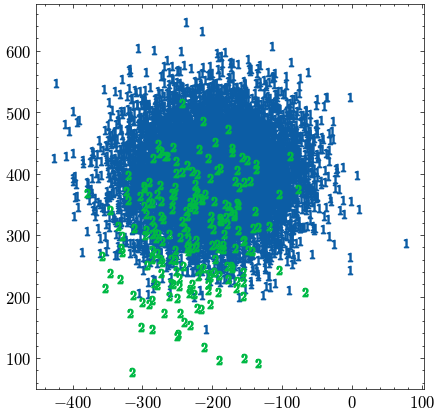

In [4]:
fig, ax = plt.subplots(figsize=(5,5))
print(noisy_sc.counts)
noisy_sc.mean().compute().scatter(ax)

## Signal denoising before clusterisation  
How denoising methods unvail relaxation events

In [26]:
import pywt

def uwt_denoise_batch(noisy_signals, wavelet='db1', level=3, threshold_type='soft', threshold_factor=1.0):
    """
    Denoise a batch of signals using Undecimated Wavelet Transform (UWT).
    
    Args:
        noisy_signals (numpy.ndarray): Array of shape (batch, signal_len) containing noisy signals.
        wavelet (str): Wavelet type to use (e.g., 'db1', 'sym4').
        level (int): Number of decomposition levels.
        threshold_type (str): Type of thresholding ('soft' or 'hard').
        threshold_factor (float): Scaling factor for noise threshold.
    
    Returns:
        numpy.ndarray: Denoised signals of the same shape as `noisy_signals`.
    """
    batch_size, signal_len = noisy_signals.shape
    denoised_signals = np.zeros_like(noisy_signals)
    
    for i in range(batch_size):
        # Decompose signal using UWT
        coeffs = pywt.swt(noisy_signals[i], wavelet, level=level)
        
        # Thresholding coefficients
        denoised_coeffs = []
        for cA, cD in coeffs:
            # Estimate noise threshold
            sigma = np.median(np.abs(cD)) / 0.6745  # Median Absolute Deviation (MAD) estimate
            threshold = threshold_factor * sigma * np.sqrt(2 * np.log(signal_len))
            
            if threshold_type == 'soft':
                cD = pywt.threshold(cD, threshold, mode='soft')
            elif threshold_type == 'hard':
                cD = pywt.threshold(cD, threshold, mode='hard')
            else:
                raise ValueError("Invalid threshold_type. Choose 'soft' or 'hard'.")
            
            denoised_coeffs.append((cA, cD))
        
        # Reconstruct signal from thresholded coefficients
        denoised_signals[i] = pywt.iswt(denoised_coeffs, wavelet)
    
    return denoised_signals

In [8]:
noisy_sc_2 = noisy_sc.filter_by_pattern("2")
ideal_sc_2 = ideal_sc.filter_by_pattern("2")

### Mean-convolve vs Whittaker-Eilers

In [63]:
denoised_signals = uwt_denoise_batch(noisy_sc_2.all_values[:,0].imag, wavelet='db1', level=3, threshold_type='hard')
denoised_signals.shape

(117, 1000)

In [64]:
size = 5
stride = 2
lamb = 100

mean_conv_noisy_sc = noisy_sc_2.mean_convolve_all(size, stride).compute()
mean_conv_ideal_sc = ideal_sc_2.mean_convolve_all(size, stride).compute()

whit_ei_noisy_sc = noisy_sc_2.whittaker_eilers_smoother_all(lamb, 2).compute()

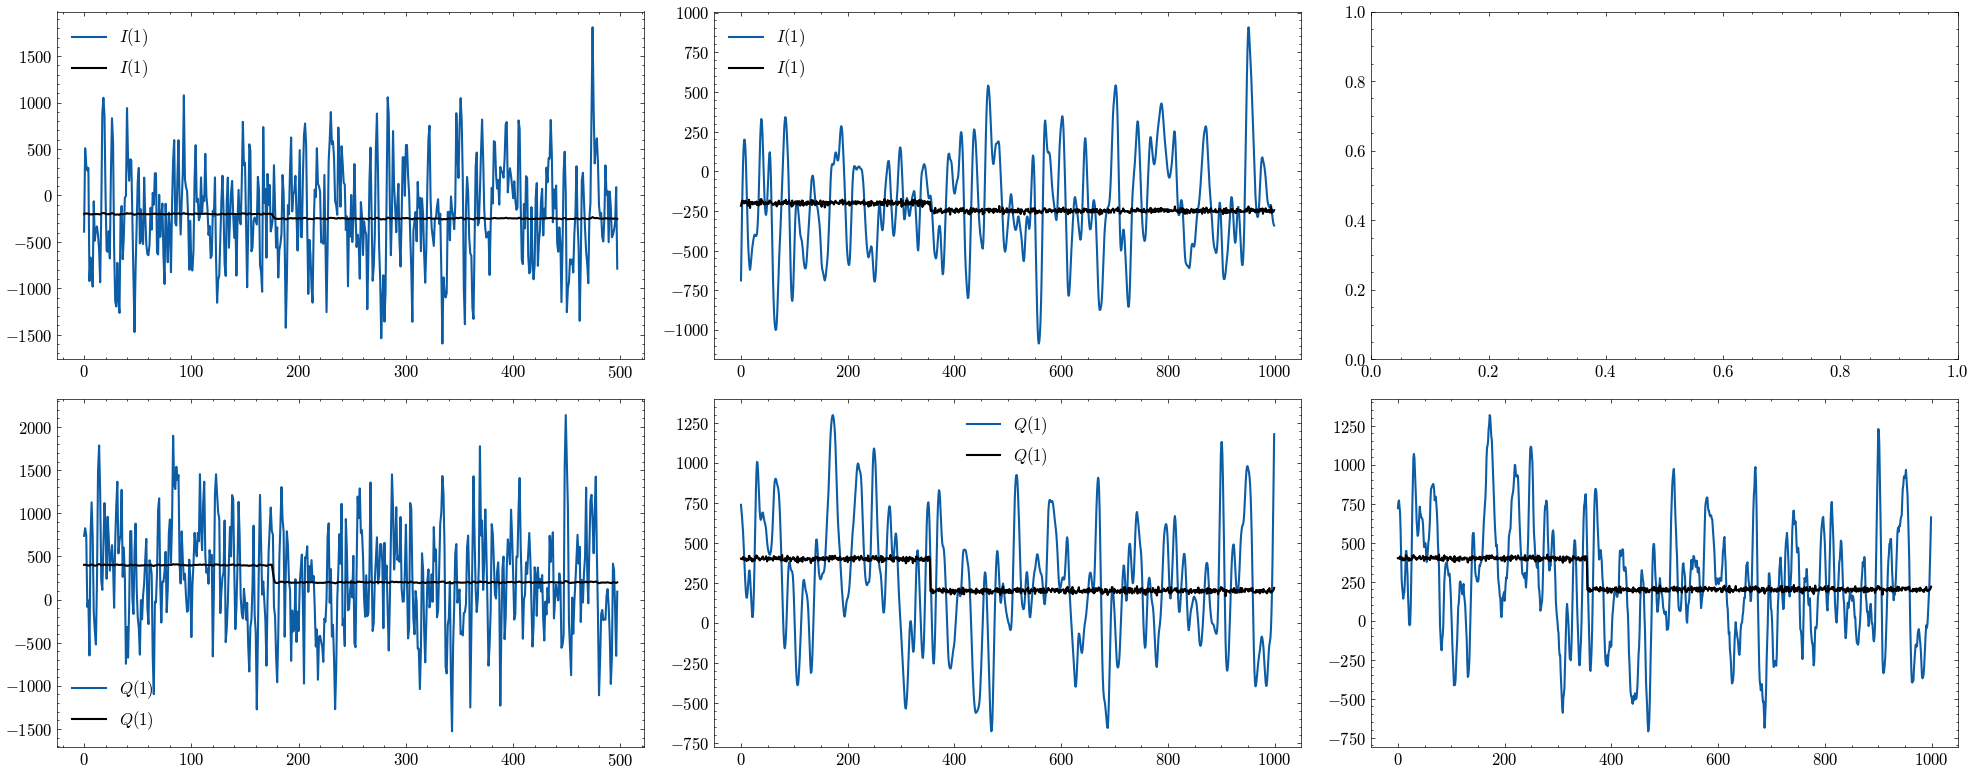

In [94]:
ind = np.random.randint(0, len(noisy_sc_2))
fig, ax = plt.subplots(2, 3, figsize=(20,8))

# noisy_sc_2[ind].plot(ax[0,0], quadrature=False, color='grey', alpha=0.5)
mean_conv_noisy_sc[ind].plot(ax[0,0], quadrature=False)
mean_conv_ideal_sc[ind].plot(ax[0,0], quadrature=False, color='black')
ax[0,0].legend()
mean_conv_noisy_sc[ind].plot(ax[1,0], in_phase=False)
mean_conv_ideal_sc[ind].plot(ax[1,0], in_phase=False, color='black')
ax[1,0].legend()

whit_ei_noisy_sc[ind].plot(ax[0,1], quadrature=False)
ideal_sc_2[ind].plot(ax[0,1], quadrature=False, color='black')
ax[0,1].legend()
whit_ei_noisy_sc[ind].plot(ax[1,1], in_phase=False)
ideal_sc_2[ind].plot(ax[1,1], in_phase=False, color='black')
ax[1,1].legend()

ax[1,2].plot(denoised_signals[ind])
ideal_sc_2[ind].plot(ax[1,2], in_phase=False, color='black')
ax[1,1].legend()

plt.tight_layout()

### Denoise Autoencoder

#### Inference

In [5]:
from pathlib import Path
from denoiser.inference import denoise_signal

In [104]:
# Get latest model from results
results_dir = Path("results")
latest_run = max(results_dir.glob("*"), key=lambda p: p.stat().st_mtime)
# model_path = latest_run / "checkpoints" / "model.pt"

# Signals to denoise
ind = np.random.randint(0, len(noisy_sc.filter_by_pattern("2")))
input_signals = noisy_sc.filter_by_pattern("2").all_values[ind,0]
real_signals = clean_sc.filter_by_pattern("2").all_values[ind,0]


# Denoise signal
denoised_data = denoise_signal(input_signals, latest_run)

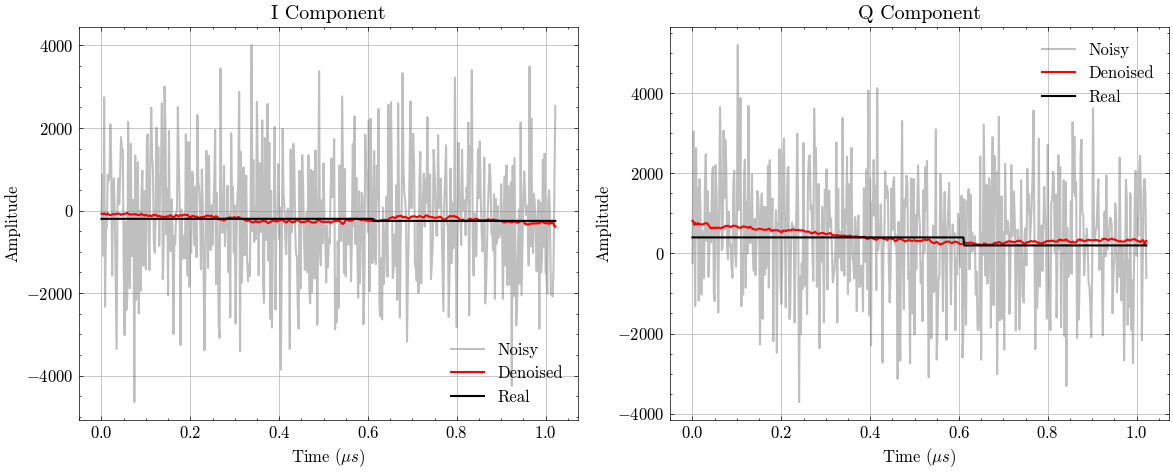

In [105]:
# Plot results
plt.figure(figsize=(12, 5))

# Plot I component
plt.subplot(1, 2, 1)
plt.plot(MEAS_TIME * 1e6, input_signals.real, "gray", alpha=0.5, label="Noisy")
plt.plot(MEAS_TIME * 1e6, denoised_data.real, "r", label="Denoised")
plt.plot(MEAS_TIME * 1e6, real_signals.real, "black", label="Real")
plt.title("I Component")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

# Plot Q component
plt.subplot(1, 2, 2)
plt.plot(MEAS_TIME * 1e6, input_signals.imag, "gray", alpha=0.5, label="Noisy")
plt.plot(MEAS_TIME * 1e6, denoised_data.imag, "r", label="Denoised")
plt.plot(MEAS_TIME * 1e6, real_signals.imag, "black", label="Real")
plt.title("Q Component")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [83]:
input_signals = noisy_sc.all_values[:,0]
real_signals = clean_sc.all_values[:,0]

# Denoise signal
denoised_data = denoise_signal(input_signals, latest_run)

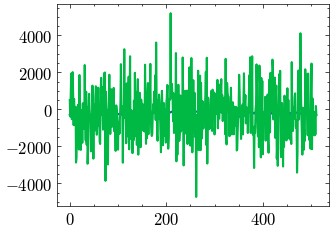

In [84]:
plt.plot(denoised_data[0].real)
plt.plot(input_signals[0].real)

In [85]:
input_signals[0].mean()

(-193.81311+290.498j)

In [86]:
denoised_data[0].mean()

(-195.38004+316.06747j)

In [27]:
denoised_sc[0].value

array([[-299.9863   +34.580273j, -325.70676  +36.602932j,
        -298.7564   +35.50626j , -318.74384  +81.152084j,
        -301.07913 +122.334755j, -307.6896  +138.0111j  ,
        -316.14874 +172.68848j , -327.39276 +165.9247j  ,
        -342.924   +160.41553j , -345.36035 +140.30052j ,
        -332.72296 +140.14204j , -324.6713  +133.45708j ,
        -324.3089  +125.15355j , -331.44467 +127.0669j  ,
        -324.74155 +121.55837j , -320.4621  +117.16448j ,
        -318.2651  +103.93108j , -344.79132 +109.15253j ,
        -346.84158 +145.31831j , -344.8212  +171.36473j ,
        -325.69174 +198.41759j , -323.60764 +201.15854j ,
        -334.25925 +194.43648j , -335.32953 +190.70537j ,
        -330.59448 +216.83966j , -331.17297 +215.91933j ,
        -334.47095 +209.89754j , -319.19824 +199.85039j ,
        -304.96155 +200.09097j , -312.60416 +193.37132j ,
        -314.55133 +184.86092j , -311.4651  +188.89433j ,
        -302.89188 +198.71114j , -291.49524 +208.58629j ,
        -300.2

In [87]:
denoised_sc = ShotCollection(_use_cython=True)
denoised_sc.extend(
    [
        SingleShot(value=value, qubits_classes=qubits_classes, _is_demodulated=True)
        for value, qubits_classes in zip(denoised_data, noisy_sc.all_qubits_classes)
    ]
)


<Axes: >

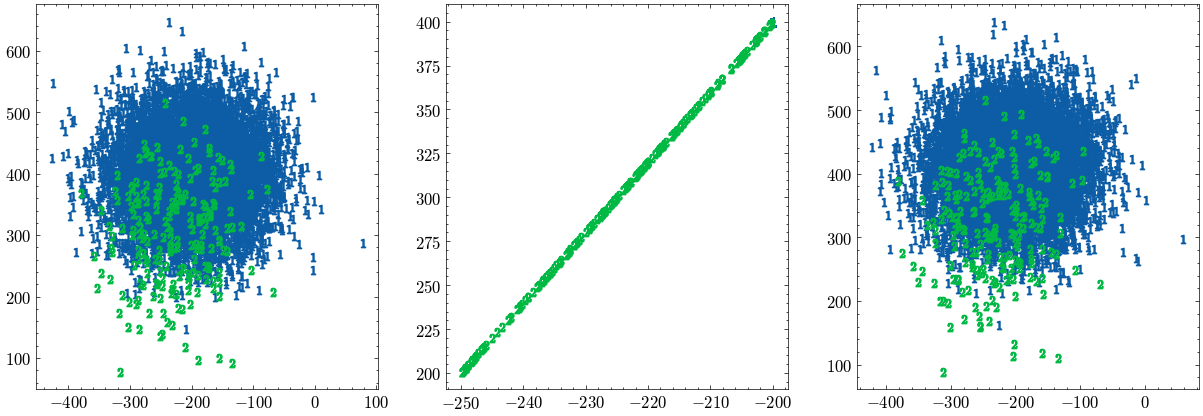

In [88]:
fig, ax = plt.subplots(ncols=3,figsize=(15,5))
# print(noisy_sc.counts)
noisy_sc.mean().compute().scatter(ax[0])
clean_sc.mean().compute().scatter(ax[1])
denoised_sc.mean().compute().scatter(ax[2])

<Axes: >

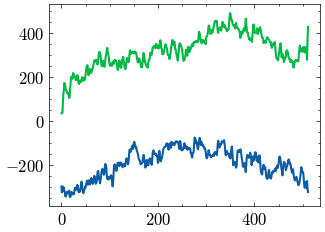

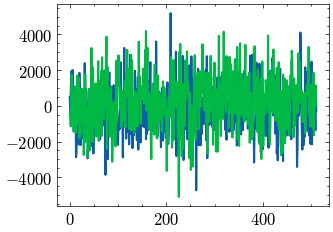

In [90]:
denoised_sc[0].plot()
noisy_sc[0].plot()